In [ ]:
%pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling open

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
from pathlib import Path
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import string

In [ ]:

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import time

## training and evaluate

## main.exe

In [ ]:
!curl -L -o /content/asl-dataset.zip https://www.kaggle.com/api/v1/datasets/download/ayuraj/asl-dataset
!unzip /content/asl-dataset.zip -d /content/
!rm /content/asl-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/asl_dataset/0/hand2_0_dif_seg_1_cropped.jpeg  
  inflating: /content/asl_dataset/0/hand2_0_dif_seg_2_cropped.jpeg  
  inflating: /content/asl_dataset/0/hand2_0_dif_seg_3_cropped.jpeg  
  inflating: /content/asl_dataset/0/hand2_0_dif_seg_4_cropped.jpeg  
  inflating: /content/asl_dataset/0/hand2_0_dif_seg_5_cropped.jpeg  
  inflating: /content/asl_dataset/0/hand2_0_left_seg_1_cropped.jpeg  
  inflating: /content/asl_dataset/0/hand2_0_left_seg_2_cropped.jpeg  
  inflating: /content/asl_dataset/0/hand2_0_left_seg_3_cropped.jpeg  
  inflating: /content/asl_dataset/0/hand2_0_left_seg_4_cropped.jpeg  
  inflating: /content/asl_dataset/0/hand2_0_left_seg_5_cropped.jpeg  
  inflating: /content/asl_dataset/0/hand2_0_right_seg_1_cropped.jpeg  
  inflating: /content/asl_dataset/0/hand2_0_right_seg_2_cropped.jpeg  
  inflating: /content/asl_dataset/0/hand2_0_right_seg_3_cropped.jpeg  
  inflating: /content/asl_dataset/0/hand2

In [ ]:
!ls /content/asl_dataset/

0  2  4  6  8  a	    b  d  f  h	j  l  n  p  r  t  v  x	z
1  3  5  7  9  asl_dataset  c  e  g  i	k  m  o  q  s  u  w  y


In [ ]:


# ==================== DATA PREPROCESSING ====================

class ASLDataPreprocessor:
    def __init__(self, min_detection_confidence=0.3):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=1,
            min_detection_confidence=min_detection_confidence,
            min_tracking_confidence=0.3,
            model_complexity=1
        )

    def add_padding(self, image, padding_percent=0.2):
        """Add padding around image to help MediaPipe detection"""
        h, w = image.shape[:2]
        pad_h = int(h * padding_percent)
        pad_w = int(w * padding_percent)

        # Add white border
        padded = cv2.copyMakeBorder(
            image, pad_h, pad_h, pad_w, pad_w,
            cv2.BORDER_CONSTANT, value=[255, 255, 255]
        )
        return padded

    def extract_landmarks(self, image_path, add_padding_flag=True):
        """Extract hand landmarks from image using MediaPipe"""
        image = cv2.imread(str(image_path))
        if image is None:
            return None

        # Add padding to help detection
        if add_padding_flag:
            image = self.add_padding(image, padding_percent=0.2)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.hands.process(image_rgb)

        if not results.multi_hand_landmarks:
            return None

        # Get first hand detected
        hand_landmarks = results.multi_hand_landmarks[0]

        # Extract 21 landmarks (x, y, z) = 63 features
        landmarks = []
        for landmark in hand_landmarks.landmark:
            landmarks.extend([landmark.x, landmark.y, landmark.z])

        return np.array(landmarks, dtype=np.float32)

    def normalize_landmarks(self, landmarks):
        """Normalize landmarks relative to wrist and hand size"""
        if landmarks is None:
            return None

        landmarks = landmarks.reshape(21, 3)

        # Get wrist position (landmark 0)
        wrist = landmarks[0]

        # Translate to wrist origin
        landmarks = landmarks - wrist

        # Calculate hand size (max distance from wrist)
        distances = np.linalg.norm(landmarks, axis=1)
        hand_size = np.max(distances)

        # Normalize by hand size (avoid division by zero)
        if hand_size > 0:
            landmarks = landmarks / hand_size

        return landmarks.flatten()

    def augment_landmarks(self, landmarks, noise_level=0.02):
        """Add slight noise for data augmentation"""
        noise = np.random.normal(0, noise_level, landmarks.shape)
        return landmarks + noise

    def process_dataset(self, dataset_path, augment=True, augment_factor=2,
                       filter_alphabet_only=True):
        """
        Process entire dataset folder structure:
        dataset_path/
            A/
                img1.jpg
                img2.jpg
            B/
                img1.jpg
            ...

        Args:
            filter_alphabet_only: If True, only process A-Z folders (skip numbers)
        """
        dataset_path = Path(dataset_path)
        X = []
        y = []

        failed_images = 0
        valid_letters = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

        # Process each letter folder
        for letter_folder in sorted(dataset_path.iterdir()):
            if not letter_folder.is_dir():
                continue

            letter = letter_folder.name.upper()

            # Filter out non-alphabet folders if requested
            if filter_alphabet_only and letter not in valid_letters:
                print(f"Skipping non-alphabet folder: {letter}")
                continue

            print(f"Processing letter: {letter}")

            # Process each image in the folder
            for img_path in list(letter_folder.glob('*.jpg')) + list(letter_folder.glob('*.png')) + list(letter_folder.glob('*.jpeg')):
                landmarks = self.extract_landmarks(img_path, add_padding_flag=True)

                if landmarks is None:
                    failed_images += 1
                    continue

                # Normalize landmarks
                normalized = self.normalize_landmarks(landmarks)

                if normalized is not None:
                    X.append(normalized)
                    y.append(letter)

                    # Data augmentation
                    if augment:
                        for _ in range(augment_factor):
                            augmented = self.augment_landmarks(normalized)
                            X.append(augmented)
                            y.append(letter)

        print(f"\nProcessing complete!")
        print(f"Successfully processed: {len(X)} samples")
        print(f"Failed to detect hands: {failed_images} images")

        return np.array(X), np.array(y)

    def save_processed_data(self, X, y, output_path='processed_data.pkl'):
        """Save processed data to file"""
        with open(output_path, 'wb') as f:
            pickle.dump({'X': X, 'y': y}, f)
        print(f"Data saved to {output_path}")

    def load_processed_data(self, input_path='processed_data.pkl'):
        """Load processed data from file"""
        with open(input_path, 'rb') as f:
            data = pickle.load(f)
        return data['X'], data['y']




    def close(self):
        self.hands.close()


# ==================== PYTORCH DATASET ====================

class ASLDataset(Dataset):
    def __init__(self, X, y, label_encoder=None):
        self.X = torch.FloatTensor(X)

        # Encode labels to integers
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            self.y = torch.LongTensor(self.label_encoder.fit_transform(y))
        else:
            self.label_encoder = label_encoder
            self.y = torch.LongTensor(self.label_encoder.transform(y))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ==================== MODEL ARCHITECTURE ====================

class ASLClassifier(nn.Module):
    def __init__(self, input_size=63, num_classes=26, dropout=0.3):
        super(ASLClassifier, self).__init__()

        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        return x



In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=50,
                learning_rate=0.001, device='cuda', save_path='best_model.pth',
                patience=10):
    """
    Train the ASL classifier with early stopping

    Args:
        model: ASL classifier model
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Maximum number of epochs
        learning_rate: Initial learning rate
        device: 'cuda' or 'cpu'
        save_path: Path to save best model
        patience: Early stopping patience

    Returns:
        history: Dictionary with training history
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                  patience=5)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rate': []
    }

    best_val_acc = 0.0
    patience_counter = 0

    print("\n" + "="*60)
    print("TRAINING START")
    print("="*60)

    for epoch in range(num_epochs):
        start_time = time.time()

        # ===== TRAINING PHASE =====
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Update progress bar
            train_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*train_correct/train_total:.2f}%'
            })

        train_loss = train_loss / train_total
        train_acc = 100. * train_correct / train_total

        # ===== VALIDATION PHASE =====
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100.*val_correct/val_total:.2f}%'
                })

        val_loss = val_loss / val_total
        val_acc = 100. * val_correct / val_total

        # Update learning rate scheduler
        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]['lr']

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rate'].append(current_lr)

        epoch_time = time.time() - start_time

        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs} - {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {current_lr:.6f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, save_path)
            print(f'✓ Best model saved! (Val Acc: {val_acc:.2f}%)')
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No improvement. Patience: {patience_counter}/{patience}')

        # Early stopping
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after {epoch+1} epochs')
            break

        print('-' * 60)

    print("\n" + "="*60)
    print("TRAINING COMPLETE")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print("="*60)

    return history


def evaluate_model(model, test_loader, device='cuda', label_encoder=None):
    """
    Evaluate model on test set

    Returns:
        accuracy: Test accuracy percentage
        loss: Average test loss
        predictions: All predictions
        true_labels: All true labels
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100. * np.sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)

    return accuracy, test_loss, np.array(all_predictions), np.array(all_labels)


def plot_training_history(history, save_path='training_history.png'):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy plot
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # Learning rate plot
    axes[2].plot(epochs, history['learning_rate'], 'g-')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].set_yscale('log')
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Training history plot saved to {save_path}")
    plt.show()


def plot_confusion_matrix(true_labels, predictions, class_names,
                         save_path='confusion_matrix.png'):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix saved to {save_path}")
    plt.show()


def print_classification_report(true_labels, predictions, class_names):
    """Print detailed classification report"""
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    report = classification_report(true_labels, predictions,
                                   target_names=class_names, digits=4)
    print(report)

    # Calculate per-class accuracy
    cm = confusion_matrix(true_labels, predictions)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\nPer-Class Accuracy:")
    print("-" * 40)
    for i, (class_name, acc) in enumerate(zip(class_names, per_class_acc)):
        print(f"{class_name}: {acc*100:.2f}%")

    # Find worst performing classes
    worst_indices = np.argsort(per_class_acc)[:5]
    print("\nWorst Performing Classes:")
    print("-" * 40)
    for idx in worst_indices:
        print(f"{class_names[idx]}: {per_class_acc[idx]*100:.2f}%")


def load_best_model(model, checkpoint_path='best_asl_model.pth', device='cuda'):
    """Load best model checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    print(f"Model loaded from {checkpoint_path}")
    print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")
    return model


# ==================== COMPLETE EVALUATION PIPELINE ====================

def full_evaluation(model, test_loader, label_encoder, device='cuda'):
    """Run complete evaluation pipeline"""
    print("\n" + "="*60)
    print("STARTING FULL EVALUATION")
    print("="*60)

    # Evaluate
    test_acc, test_loss, predictions, true_labels = evaluate_model(
        model, test_loader, device
    )

    print(f"\nTest Accuracy: {test_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Get class names
    class_names = label_encoder.classes_

    # Print classification report
    print_classification_report(true_labels, predictions, class_names)

    # Plot confusion matrix
    plot_confusion_matrix(true_labels, predictions, class_names)

    print("\n" + "="*60)
    print("EVALUATION COMPLETE")
    print("="*60)

    return test_acc, test_loss

=== Starting Data Preprocessing ===
Skipping non-alphabet folder: 0
Skipping non-alphabet folder: 1
Skipping non-alphabet folder: 2
Skipping non-alphabet folder: 3
Skipping non-alphabet folder: 4
Skipping non-alphabet folder: 5
Skipping non-alphabet folder: 6
Skipping non-alphabet folder: 7
Skipping non-alphabet folder: 8
Skipping non-alphabet folder: 9
Processing letter: A
Skipping non-alphabet folder: ASL_DATASET
Processing letter: B
Processing letter: C
Processing letter: D
Processing letter: E
Processing letter: F
Processing letter: G
Processing letter: H
Processing letter: I
Processing letter: J
Processing letter: K
Processing letter: L
Processing letter: M
Processing letter: N
Processing letter: O
Processing letter: P
Processing letter: Q
Processing letter: R
Processing letter: S
Processing letter: T
Processing letter: U
Processing letter: V
Processing letter: W
Processing letter: X
Processing letter: Y
Processing letter: Z

Processing complete!
Successfully processed: 4740 sampl

Epoch 1/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 199.37it/s, loss=2.0626, acc=73.98%]



Epoch 1/50 - 0.98s
Train Loss: 2.4615 | Train Acc: 38.91%
Val Loss: 1.9656 | Val Acc: 73.98%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 73.98%)
------------------------------------------------------------


Epoch 2/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 471.57it/s, loss=0.9824, acc=84.53%]



Epoch 2/50 - 0.25s
Train Loss: 1.5236 | Train Acc: 71.82%
Val Loss: 1.0525 | Val Acc: 84.53%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 84.53%)
------------------------------------------------------------


Epoch 3/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 443.24it/s, loss=0.5066, acc=93.25%]



Epoch 3/50 - 0.24s
Train Loss: 1.0138 | Train Acc: 81.92%
Val Loss: 0.6338 | Val Acc: 93.25%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 93.25%)
------------------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 459.14it/s, loss=0.3593, acc=95.92%]



Epoch 4/50 - 0.23s
Train Loss: 0.7232 | Train Acc: 86.26%
Val Loss: 0.4676 | Val Acc: 95.92%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 95.92%)
------------------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 396.03it/s, loss=0.2050, acc=97.05%]



Epoch 5/50 - 0.24s
Train Loss: 0.5554 | Train Acc: 89.54%
Val Loss: 0.3055 | Val Acc: 97.05%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 97.05%)
------------------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 371.44it/s, loss=0.1618, acc=97.47%]



Epoch 6/50 - 0.28s
Train Loss: 0.4408 | Train Acc: 91.38%
Val Loss: 0.2394 | Val Acc: 97.47%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 97.47%)
------------------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 427.23it/s, loss=0.0996, acc=98.03%]



Epoch 7/50 - 0.26s
Train Loss: 0.3680 | Train Acc: 92.53%
Val Loss: 0.1964 | Val Acc: 98.03%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 98.03%)
------------------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 394.61it/s, loss=0.0785, acc=98.73%]



Epoch 8/50 - 0.24s
Train Loss: 0.3139 | Train Acc: 93.49%
Val Loss: 0.1397 | Val Acc: 98.73%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 98.73%)
------------------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 343.24it/s, loss=0.0504, acc=98.59%]



Epoch 9/50 - 0.25s
Train Loss: 0.2625 | Train Acc: 94.73%
Val Loss: 0.1247 | Val Acc: 98.59%
Learning Rate: 0.001000
No improvement. Patience: 1/10
------------------------------------------------------------


Epoch 10/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 441.25it/s, loss=0.0322, acc=99.30%]



Epoch 10/50 - 0.27s
Train Loss: 0.2388 | Train Acc: 94.85%
Val Loss: 0.0992 | Val Acc: 99.30%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 99.30%)
------------------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 382.70it/s, loss=0.0350, acc=99.16%]



Epoch 11/50 - 0.24s
Train Loss: 0.2106 | Train Acc: 95.06%
Val Loss: 0.0836 | Val Acc: 99.16%
Learning Rate: 0.001000
No improvement. Patience: 1/10
------------------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 475.31it/s, loss=0.0203, acc=98.73%]



Epoch 12/50 - 0.25s
Train Loss: 0.1976 | Train Acc: 95.45%
Val Loss: 0.0755 | Val Acc: 98.73%
Learning Rate: 0.001000
No improvement. Patience: 2/10
------------------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 398.30it/s, loss=0.0180, acc=98.87%]



Epoch 13/50 - 0.25s
Train Loss: 0.1758 | Train Acc: 96.29%
Val Loss: 0.0636 | Val Acc: 98.87%
Learning Rate: 0.001000
No improvement. Patience: 3/10
------------------------------------------------------------


Epoch 14/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 485.24it/s, loss=0.0149, acc=99.30%]



Epoch 14/50 - 0.26s
Train Loss: 0.1659 | Train Acc: 95.90%
Val Loss: 0.0547 | Val Acc: 99.30%
Learning Rate: 0.001000
No improvement. Patience: 4/10
------------------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 485.69it/s, loss=0.0267, acc=98.45%]



Epoch 15/50 - 0.24s
Train Loss: 0.1515 | Train Acc: 96.78%
Val Loss: 0.0709 | Val Acc: 98.45%
Learning Rate: 0.001000
No improvement. Patience: 5/10
------------------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 452.39it/s, loss=0.0109, acc=99.16%]



Epoch 16/50 - 0.24s
Train Loss: 0.1434 | Train Acc: 96.65%
Val Loss: 0.0530 | Val Acc: 99.16%
Learning Rate: 0.000500
No improvement. Patience: 6/10
------------------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 388.56it/s, loss=0.0085, acc=99.16%]



Epoch 17/50 - 0.24s
Train Loss: 0.1241 | Train Acc: 97.26%
Val Loss: 0.0365 | Val Acc: 99.16%
Learning Rate: 0.000500
No improvement. Patience: 7/10
------------------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 404.95it/s, loss=0.0083, acc=99.58%]



Epoch 18/50 - 0.26s
Train Loss: 0.1172 | Train Acc: 97.35%
Val Loss: 0.0332 | Val Acc: 99.58%
Learning Rate: 0.000500
✓ Best model saved! (Val Acc: 99.58%)
------------------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 450.27it/s, loss=0.0091, acc=99.72%]



Epoch 19/50 - 0.24s
Train Loss: 0.1131 | Train Acc: 97.29%
Val Loss: 0.0296 | Val Acc: 99.72%
Learning Rate: 0.000500
✓ Best model saved! (Val Acc: 99.72%)
------------------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 495.94it/s, loss=0.0057, acc=99.30%]



Epoch 20/50 - 0.26s
Train Loss: 0.1181 | Train Acc: 97.20%
Val Loss: 0.0359 | Val Acc: 99.30%
Learning Rate: 0.000500
No improvement. Patience: 1/10
------------------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 408.84it/s, loss=0.0067, acc=99.72%]



Epoch 21/50 - 0.30s
Train Loss: 0.0982 | Train Acc: 97.80%
Val Loss: 0.0274 | Val Acc: 99.72%
Learning Rate: 0.000500
No improvement. Patience: 2/10
------------------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 426.96it/s, loss=0.0045, acc=99.58%]



Epoch 22/50 - 0.27s
Train Loss: 0.1014 | Train Acc: 97.62%
Val Loss: 0.0256 | Val Acc: 99.58%
Learning Rate: 0.000500
No improvement. Patience: 3/10
------------------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 293.56it/s, loss=0.0061, acc=99.30%]



Epoch 23/50 - 0.27s
Train Loss: 0.1001 | Train Acc: 97.20%
Val Loss: 0.0284 | Val Acc: 99.30%
Learning Rate: 0.000500
No improvement. Patience: 4/10
------------------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 474.54it/s, loss=0.0035, acc=100.00%]



Epoch 24/50 - 0.24s
Train Loss: 0.0993 | Train Acc: 97.23%
Val Loss: 0.0220 | Val Acc: 100.00%
Learning Rate: 0.000500
✓ Best model saved! (Val Acc: 100.00%)
------------------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 429.32it/s, loss=0.0034, acc=100.00%]



Epoch 25/50 - 0.24s
Train Loss: 0.0897 | Train Acc: 97.80%
Val Loss: 0.0196 | Val Acc: 100.00%
Learning Rate: 0.000500
No improvement. Patience: 1/10
------------------------------------------------------------


Epoch 26/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 365.17it/s, loss=0.0038, acc=99.72%]



Epoch 26/50 - 0.30s
Train Loss: 0.0873 | Train Acc: 97.86%
Val Loss: 0.0228 | Val Acc: 99.72%
Learning Rate: 0.000500
No improvement. Patience: 2/10
------------------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 393.23it/s, loss=0.0050, acc=99.58%]



Epoch 27/50 - 0.29s
Train Loss: 0.0792 | Train Acc: 98.31%
Val Loss: 0.0225 | Val Acc: 99.58%
Learning Rate: 0.000500
No improvement. Patience: 3/10
------------------------------------------------------------


Epoch 28/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 483.89it/s, loss=0.0042, acc=100.00%]



Epoch 28/50 - 0.25s
Train Loss: 0.0982 | Train Acc: 97.53%
Val Loss: 0.0178 | Val Acc: 100.00%
Learning Rate: 0.000500
No improvement. Patience: 4/10
------------------------------------------------------------


Epoch 29/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 486.80it/s, loss=0.0027, acc=100.00%]



Epoch 29/50 - 0.25s
Train Loss: 0.0842 | Train Acc: 97.68%
Val Loss: 0.0147 | Val Acc: 100.00%
Learning Rate: 0.000500
No improvement. Patience: 5/10
------------------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 319.47it/s, loss=0.0040, acc=99.72%]



Epoch 30/50 - 0.26s
Train Loss: 0.0849 | Train Acc: 97.68%
Val Loss: 0.0205 | Val Acc: 99.72%
Learning Rate: 0.000250
No improvement. Patience: 6/10
------------------------------------------------------------


Epoch 31/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 293.21it/s, loss=0.0029, acc=99.86%]



Epoch 31/50 - 0.39s
Train Loss: 0.0725 | Train Acc: 98.19%
Val Loss: 0.0145 | Val Acc: 99.86%
Learning Rate: 0.000250
No improvement. Patience: 7/10
------------------------------------------------------------


Epoch 32/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 300.22it/s, loss=0.0028, acc=100.00%]



Epoch 32/50 - 0.40s
Train Loss: 0.0768 | Train Acc: 98.13%
Val Loss: 0.0135 | Val Acc: 100.00%
Learning Rate: 0.000250
No improvement. Patience: 8/10
------------------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 330.88it/s, loss=0.0031, acc=99.72%]



Epoch 33/50 - 0.34s
Train Loss: 0.0739 | Train Acc: 98.25%
Val Loss: 0.0141 | Val Acc: 99.72%
Learning Rate: 0.000250
No improvement. Patience: 9/10
------------------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 358.68it/s, loss=0.0026, acc=100.00%]



Epoch 34/50 - 0.31s
Train Loss: 0.0765 | Train Acc: 97.95%
Val Loss: 0.0131 | Val Acc: 100.00%
Learning Rate: 0.000250
No improvement. Patience: 10/10

Early stopping triggered after 34 epochs

TRAINING COMPLETE
Best Validation Accuracy: 100.00%

=== Final Evaluation on Test Set ===


Evaluating: 100%|██████████| 12/12 [00:00<00:00, 682.22it/s]


Test Accuracy: 99.72%
Test Loss: 0.0165
Training history plot saved to training_history.png


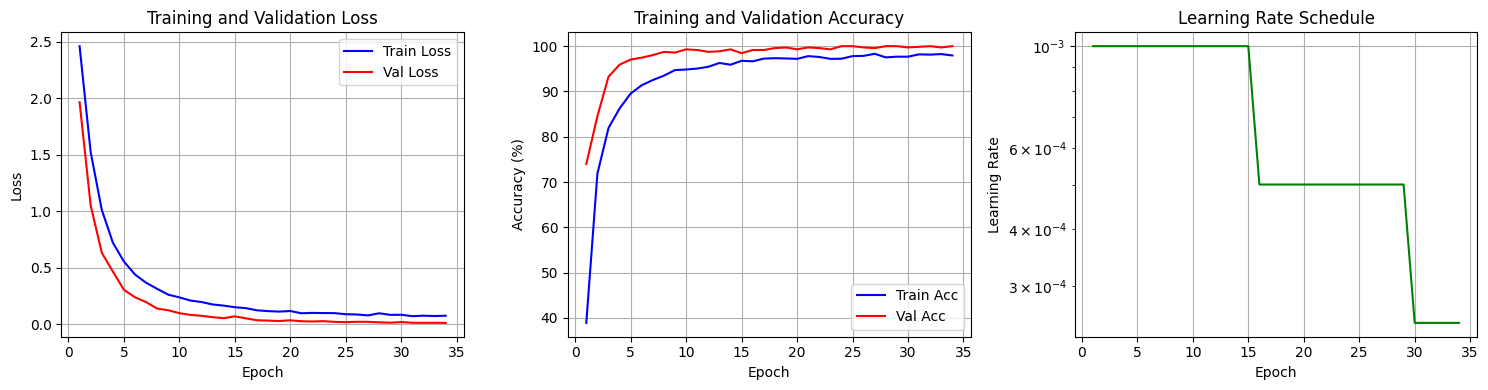

In [ ]:
# ==================== USAGE EXAMPLE ====================

if __name__ == "__main__":
    # Set random seed for reproducibility
    seed = 12345
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # If you use other libraries that involve randomness, set their seeds here too.

    # Step 1: Preprocess dataset
    print("=== Starting Data Preprocessing ===")
    preprocessor = ASLDataPreprocessor()

    # Process your dataset (adjust path)
    dataset_path = "/content/asl_dataset/"  # Change this to your dataset path
    X, y = preprocessor.process_dataset(dataset_path, augment=True, augment_factor=2)

    # Save processed data
    preprocessor.save_processed_data(X, y, 'asl_processed.pkl')
    preprocessor.close()

    # Step 2: Split data with minimum samples filter
    print("\n=== Splitting Dataset ===")

    # Filter out classes with too few samples
    min_samples_per_class = 10  # Minimum 10 samples to keep a class
    class_counts = {}
    for label in y:
        class_counts[label] = class_counts.get(label, 0) + 1

    # Identify classes to keep
    valid_classes = {label for label, count in class_counts.items() if count >= min_samples_per_class}

    if len(valid_classes) < len(class_counts):
        removed = set(class_counts.keys()) - valid_classes
        print(f"⚠ Removing {len(removed)} classes with < {min_samples_per_class} samples: {sorted(removed)}")

        # Filter dataset
        mask = np.array([label in valid_classes for label in y])
        X = X[mask]
        y = y[mask]

        print(f"Remaining samples: {len(X)}")
        print(f"Remaining classes: {len(valid_classes)}")

    if len(X) == 0:
        print("❌ ERROR: No samples remaining after filtering!")
        exit(1)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # Step 3: Create datasets
    train_dataset = ASLDataset(X_train, y_train)
    val_dataset = ASLDataset(X_val, y_val, label_encoder=train_dataset.label_encoder)
    test_dataset = ASLDataset(X_test, y_test, label_encoder=train_dataset.label_encoder)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Step 4: Initialize model
    print("\n=== Model Architecture ===")
    num_classes = len(train_dataset.label_encoder.classes_)
    model = ASLClassifier(input_size=63, num_classes=num_classes, dropout=0.3)

    # Print model summary
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {train_dataset.label_encoder.classes_}")

    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}")
    model = model.to(device)

    print("\n=== Ready for Training ===")

    # Step 5: Train the model


    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=50,
        learning_rate=0.001,
        device=device,
        save_path='best_asl_model.pth'
    )

    # Step 6: Evaluate on test set
    print("\n=== Final Evaluation on Test Set ===")
    test_accuracy, test_loss, predictions, true_labels = evaluate_model(
        model=model,
        test_loader=test_loader,
        device=device
    )

    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Plot training history
    plot_training_history(history)

In [ ]:
# --> ADD THIS TO YOUR TRAINING SCRIPT <--
import pickle

# Save the label encoder from the training dataset
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(train_dataset.label_encoder, f)
print("✅ Label encoder saved to label_encoder.pkl")

✅ Label encoder saved to label_encoder.pkl



STARTING FULL EVALUATION


Evaluating: 100%|██████████| 12/12 [00:00<00:00, 910.96it/s]


Test Accuracy: 99.72%
Test Loss: 0.0165

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           A     1.0000    1.0000    1.0000        30
           B     1.0000    1.0000    1.0000        29
           C     1.0000    1.0000    1.0000        26
           D     1.0000    0.9630    0.9811        27
           E     1.0000    1.0000    1.0000        25
           F     1.0000    1.0000    1.0000        31
           G     1.0000    1.0000    1.0000        24
           H     1.0000    1.0000    1.0000        27
           I     1.0000    1.0000    1.0000        30
           J     1.0000    1.0000    1.0000        25
           K     1.0000    1.0000    1.0000        32
           L     1.0000    1.0000    1.0000        31
           M     1.0000    1.0000    1.0000        20
           N     1.0000    1.0000    1.0000        25
           O     1.0000    1.0000    1.0000        25
           P     1.0000    1.0000    1.0000        27
           Q     

Confusion matrix saved to confusion_matrix.png


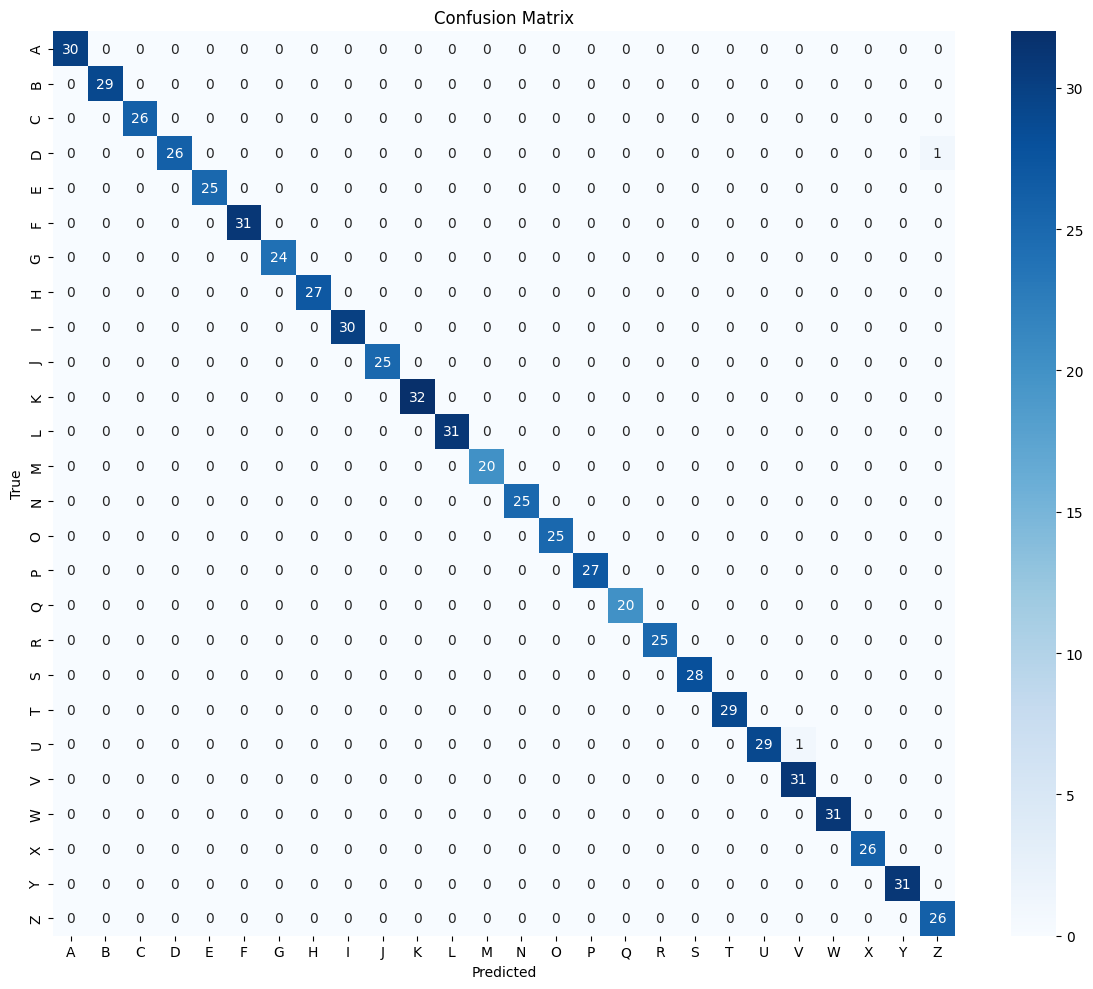


EVALUATION COMPLETE


(99.71870604781998, 0.016494706292072135)

In [ ]:
full_evaluation(model, test_loader, test_dataset.label_encoder)

## test model with real image

In [ ]:
def predict_single_image(model_path, encoder_path, image_path, device):
    """
    Loads the model and predicts the class for a single image.
    """
    # 1. Load the Label Encoder
    with open(encoder_path, 'rb') as f:
        label_encoder = pickle.load(f)
    num_classes = len(label_encoder.classes_)

    # 2. Initialize Model and Load Weights
    model = ASLClassifier(num_classes=num_classes)

    # --- THIS IS THE FIX ---
    # Load the entire checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    # Extract the model's state dictionary
    model.load_state_dict(checkpoint['model_state_dict'])
    # --- END OF FIX ---

    model.to(device)
    model.eval() # IMPORTANT: Set model to evaluation mode

    # 3. Preprocess the Image
    preprocessor = ASLDataPreprocessor()

    # Also, I noticed a trailing space in your image path, let's remove it
    landmarks = preprocessor.extract_landmarks(image_path.strip())

    if landmarks is None:
        preprocessor.close()
        return "Hand not detected in the image.", None

    normalized_landmarks = preprocessor.normalize_landmarks(landmarks)
    preprocessor.close() # Clean up MediaPipe

    # 4. Convert to Tensor
    input_tensor = torch.FloatTensor(normalized_landmarks).unsqueeze(0).to(device)

    # 5. Make Prediction
    with torch.no_grad(): # No need to calculate gradients for inference
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)

    predicted_label = label_encoder.inverse_transform([predicted_idx.item()])[0]

    return predicted_label, confidence.item()

In [ ]:
if __name__ == "__main__":
    # --- Configuration ---
    MODEL_PATH = '/content/best_asl_model.pth'      # Path to your trained model
    ENCODER_PATH = '/content/label_encoder.pkl'     # Path to your saved label encoder
    IMAGE_TO_TEST = '/content/asl_dataset/k/hand1_k_bot_seg_1_cropped.jpeg' # <-- CHANGE THIS to your image path

    # Set device (CPU or GPU)
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {DEVICE}")
    seed = 12345
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # --- Run Prediction ---
    predicted_char, confidence_score = predict_single_image(MODEL_PATH, ENCODER_PATH, IMAGE_TO_TEST, DEVICE)

    if confidence_score is not None:
        print(f"\nPrediction Successful! 🎉")
        print(f"Predicted Character: '{predicted_char}'")
        print(f"Confidence: {confidence_score * 100:.2f}%")
    else:
        print(f"\nPrediction Failed: {predicted_char}")


Using device: cuda

Prediction Successful! 🎉
Predicted Character: 'K'
Confidence: 99.89%


In [ ]:
!ls /content/asl_dataset/a

hand1_a_bot_seg_1_cropped.jpeg	  hand2_a_left_seg_1_cropped.jpeg
hand1_a_bot_seg_2_cropped.jpeg	  hand2_a_left_seg_2_cropped.jpeg
hand1_a_bot_seg_3_cropped.jpeg	  hand2_a_left_seg_3_cropped.jpeg
hand1_a_bot_seg_4_cropped.jpeg	  hand2_a_left_seg_4_cropped.jpeg
hand1_a_bot_seg_5_cropped.jpeg	  hand2_a_left_seg_5_cropped.jpeg
hand1_a_dif_seg_1_cropped.jpeg	  hand2_a_right_seg_1_cropped.jpeg
hand1_a_dif_seg_2_cropped.jpeg	  hand2_a_right_seg_2_cropped.jpeg
hand1_a_dif_seg_3_cropped.jpeg	  hand2_a_right_seg_3_cropped.jpeg
hand1_a_dif_seg_4_cropped.jpeg	  hand2_a_right_seg_4_cropped.jpeg
hand1_a_dif_seg_5_cropped.jpeg	  hand2_a_right_seg_5_cropped.jpeg
hand1_a_left_seg_1_cropped.jpeg   hand2_a_top_seg_1_cropped.jpeg
hand1_a_left_seg_2_cropped.jpeg   hand2_a_top_seg_2_cropped.jpeg
hand1_a_left_seg_3_cropped.jpeg   hand2_a_top_seg_3_cropped.jpeg
hand1_a_left_seg_4_cropped.jpeg   hand2_a_top_seg_4_cropped.jpeg
hand1_a_left_seg_5_cropped.jpeg   hand2_a_top_seg_5_cropped.jpeg
hand1_a_right_seg_1_

In [ ]:
!ls /content/

asl_dataset	    confusion_matrix.png  training_history.png
asl_processed.pkl   label_encoder.pkl
best_asl_model.pth  sample_data
